# Periodogram Averaging
En esta notebook se desarrolla la función que implementa el algoritmo de promedio de periodogramas, también conocido como el método welch-bartlett, y se realizan pruebas para validar su funcionamiento utilizando ruido blanco gaussiano y observando cómo se comporta la estimación espectral según diferentes parámetros.

In [18]:
import matplotlib.pyplot as plt

In [19]:
from scipy import signal

In [20]:
import numpy as np

In [21]:
import seaborn as sns

In [22]:
sns.set_style('dark')
sns.set_context('paper')
sns.set_palette('viridis')

In [23]:
def periodogram_averaging(x: np.array, window_size: int, overlap: float = 0.0, window: str = 'boxcar') -> np.array:
    """ Apply the welch-bartlett method (averaging periodograms) to estimate a signal's power spectrum.
        @param x Samples of the random signal realization    
        @param window_size Size of the window
        @param overlap Overlapping factor [0.0, 1.0)  
        @param window Type of window
        @return Power spectrum density estimation
    """
    # Validate the type of window
    if type(window) is not str:
        raise ValueError('Window must be a string value, unexpected type of data')
    
    # Validate signal samples
    if type(x) is not np.array and type(x) is not np.ndarray:
        raise ValueError('Signal samples must be np.array, unexpected type of data')
    elif x.ndim > 1:
        raise ValueError('The signal samples argument must be 1D')
        
    # Validate the window size
    if type(window_size) is not int:
        raise ValueError('Window size must be an integer value, unexpected type of data')
    elif window_size < 1 or window_size >= len(x):
        raise ValueError('Window size out of range')
    
    # Validate the overlapping
    if type(overlap) is not float:
        raise ValueError('The overlap must be a decimal value, unexpected type of data')
    elif overlap < 0.0 or overlap >= 1.0:
        raise ValueError('Overlapping factor out of range')
    
    # Compute algorithm parameters based on the arguments passed to the function
    N = len(x)
    L = window_size
    D = int(L * (1 - overlap))
    K = int((N - L + 1) / D) + 1
    
    # Create the periodogram matrix and compute i-th segment periodogram
    periodograms = np.zeros((K, L))
    segment = np.zeros((L))
    for k in range(K):
        segment = x[k * D:k * D + L]
        _, periodograms[k,:] = signal.periodogram(segment, window=window, return_onesided = False)
    # Squash and average periodograms
    return periodograms.sum(axis=0) / K

## Banco de pruebas
Se realiza una función para facilitar el proceso de pruebas, mediante la cual se genera una señal de ruido blanco gaussiando de media nula y desvío estándar unitario, y se compara la estimación espectral obtenida a partir del periodograma básico y el periodogram con promedios.

In [24]:
def periodogram_averaging_testbench(samples: int, window_size: int, overlap: float, window: str = 'boxcar'):
    """ Testbench for the periodogram average function
        @param samples Amount of samples for the white noise generator
        @param window_size Size of the window
        @param overlap Overlapping factor
        @param window Type of window
    """
    # Generate white gaussian noise with zero mean and unity standard deviation
    white_noise = np.random.normal(size=samples)
    
    # Estimate the power spectrum density of the white noise with the periodogram
    _, psd_periodogram = signal.periodogram(white_noise, window=window)
    
    # Estimate the power spectrum density of the white noise with the periodogram averaging
    psd_periodogram_average = periodogram_averaging(white_noise, window_size, overlap, window=window)
    
    # Plot the result
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{samples} samples of white noise $\mu=0$ $\sigma=1$', fontsize=18)
    
    ax[0].plot(np.arange(0, np.pi, (np.pi) / len(psd_periodogram)), psd_periodogram)
    ax[0].set_title('Periodogram', fontsize=15)
    ax[0].set_xlabel('Frequency [$Hz$]', fontsize=12)
    ax[0].set_ylabel('PSD', fontsize=12)
    ax[0].grid()
    
    ax[1].set_title(f'Periodogram average of {window_size} window size {overlap * 100}% overlap', fontsize=15)
    ax[1].plot(np.arange(0, np.pi, (np.pi) / len(psd_periodogram_average)), psd_periodogram_average)
    ax[1].set_xlabel('Frequency [$Hz$]', fontsize=12)
    ax[1].set_ylabel('PSD', fontsize=12)
    ax[1].grid()

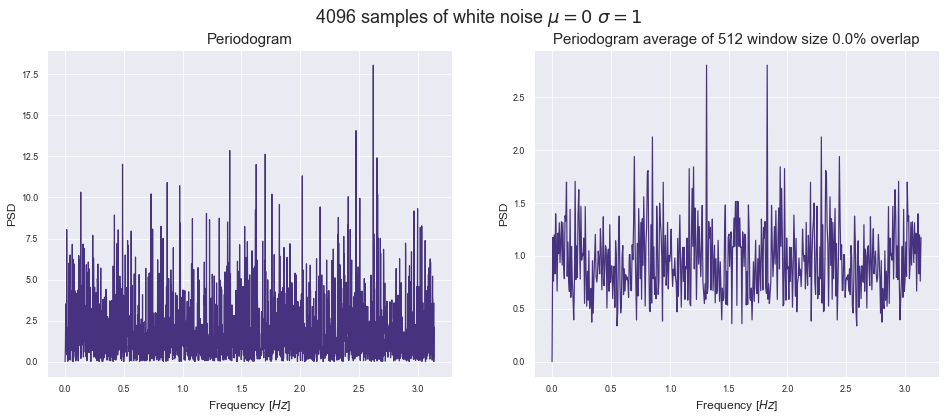

In [25]:
periodogram_averaging_testbench(4096, 512, 0.0, window='boxcar')

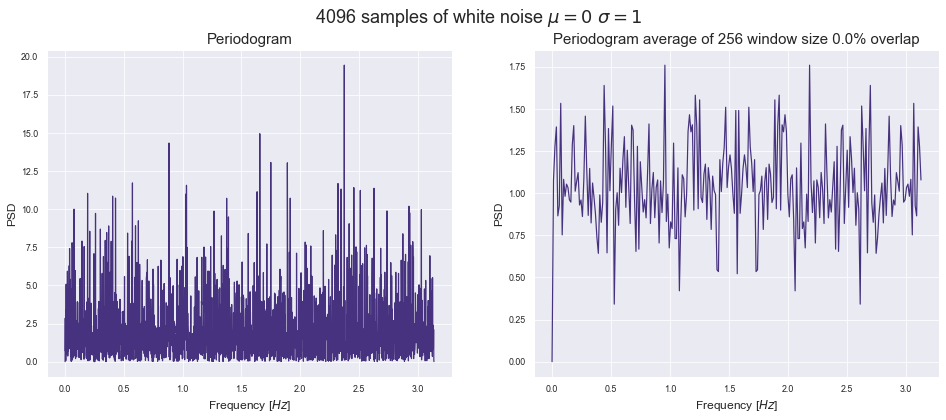

In [26]:
periodogram_averaging_testbench(4096, 256, 0.0, window='boxcar')

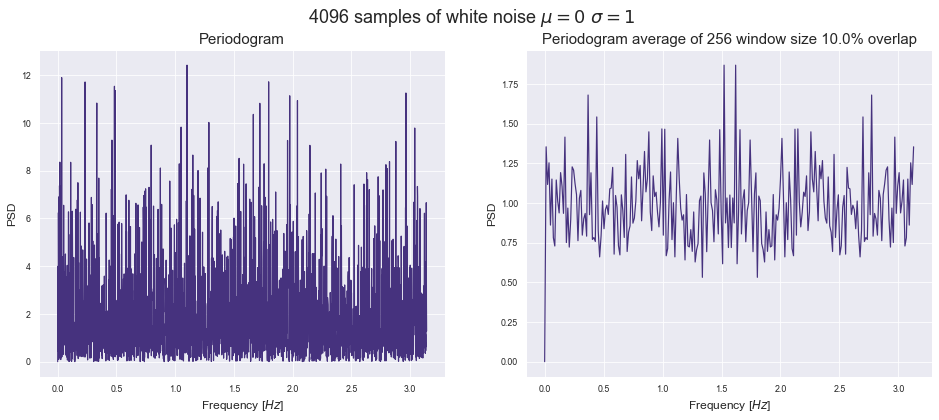

In [27]:
periodogram_averaging_testbench(4096, 256, 0.10, window='boxcar')

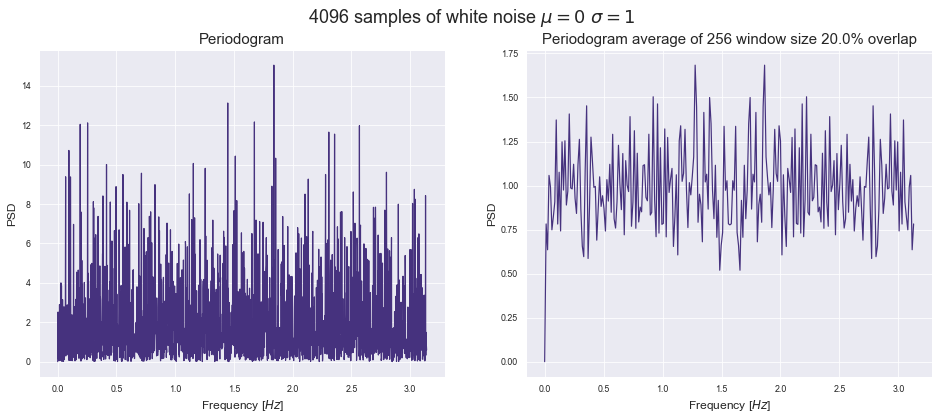

In [28]:
periodogram_averaging_testbench(4096, 256, 0.20, window='boxcar')

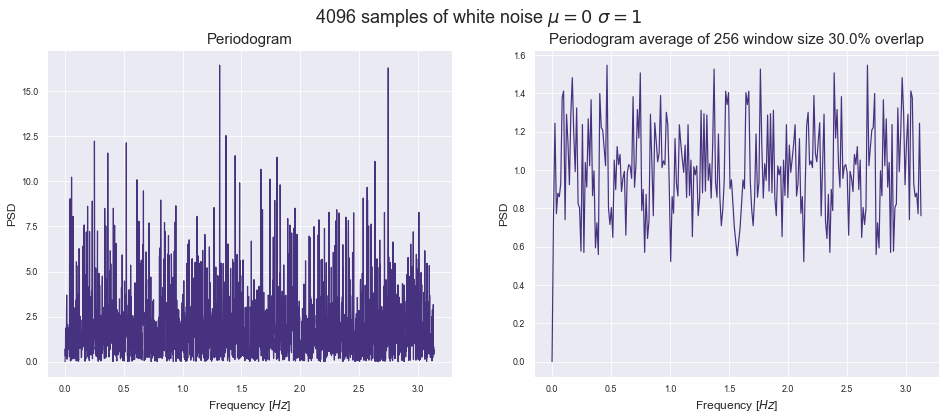

In [29]:
periodogram_averaging_testbench(4096, 256, 0.30, window='boxcar')

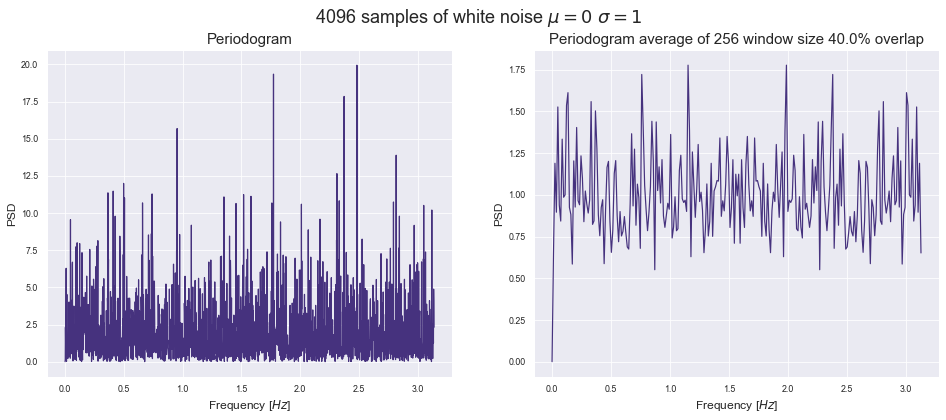

In [30]:
periodogram_averaging_testbench(4096, 256, 0.40, window='boxcar')

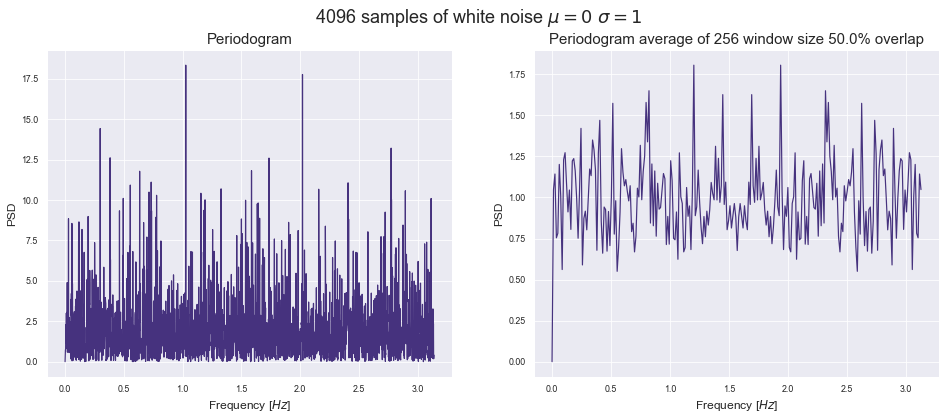

In [31]:
periodogram_averaging_testbench(4096, 256, 0.50, window='boxcar')

## Comparación con Scipy
En esta sección se constrastan los resultados obtenidos por nuestra implementación, contra la implementación de Scipy (biblioteca de Python).

In [32]:
def periodogram_averaging_compare(samples: int, window_size: int, overlap: float, window: str = 'boxcar'):
    """ Compare the results of the periodogram averaging
        @param samples Amount of samples for the white noise generator
        @param window_size Size of the window
        @param overlap Overlapping factor
        @param window Type of window
    """
    # Generate white gaussian noise with zero mean and unity standard deviation
    white_noise = np.random.normal(size=samples)
    
    # Estimate the power spectrum density of the white noise with the periodogram
    _, scipy_welch = signal.welch(white_noise, window=window, noverlap=int(overlap * window_size), nperseg=window_size)
    
    # Estimate the power spectrum density of the white noise with the periodogram averaging
    custom_welch = periodogram_averaging(white_noise, window_size, overlap, window=window)
    
    # Plot the result
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{samples} samples of white noise $\mu=0$ $\sigma=1$', fontsize=18)
    
    ax[0].plot(np.arange(0, np.pi, (np.pi) / len(scipy_welch)), scipy_welch)
    ax[0].set_title('Scipy implementation', fontsize=15)
    ax[0].set_xlabel('Frequency [$Hz$]', fontsize=12)
    ax[0].set_ylabel('PSD', fontsize=12)
    ax[0].grid()
    
    ax[1].set_title(f'Our implementation', fontsize=15)
    ax[1].plot(np.arange(0, np.pi, (np.pi) / len(custom_welch)), custom_welch)
    ax[1].set_xlabel('Frequency [$Hz$]', fontsize=12)
    ax[1].set_ylabel('PSD', fontsize=12)
    ax[1].grid()

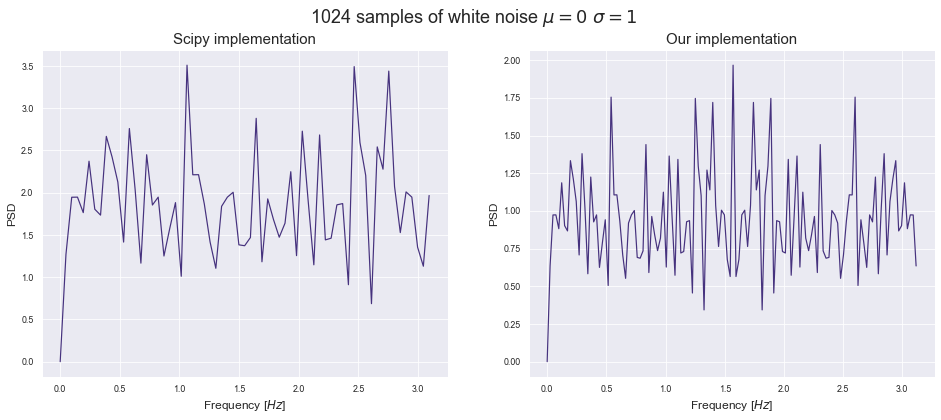

In [33]:
periodogram_averaging_compare(1024, 128, 0.0, window='boxcar')